In [22]:
import numpy as np
from scipy.stats import mannwhitneyu, uniform, norm, binom_test
from matplotlib import pyplot as plt

In [24]:
def test_mann_whitney(first_distr, second_distr, sample_size, significance_level=0.05, n_tests=10000):
    positive_results = 0
    for i in range(n_tests):
        first_sample = first_distr.rvs(sample_size)
        second_sample = second_distr.rvs(sample_size)
        pvalue = mannwhitneyu(first_sample, second_sample, alternative='two-sided').pvalue
        if pvalue < significance_level:
            positive_results += 1
    rate = positive_results / n_tests
    print(f"{rate} ({positive_results} из {n_tests} экспериментов)")
    return rate

def plot_distributions(first_distr, second_distr):
    plt.figure(figsize=(16, 8))
    x = np.linspace(-3, 3, 1001)
    plt.plot(x, first_distr.pdf(x))
    plt.fill_between(x, np.zeros_like(x), first_distr.pdf(x), alpha=0.3)
    plt.plot(x, second_distr.pdf(x))
    plt.fill_between(x, np.zeros_like(x), second_distr.pdf(x), alpha=0.3)
    plt.show()


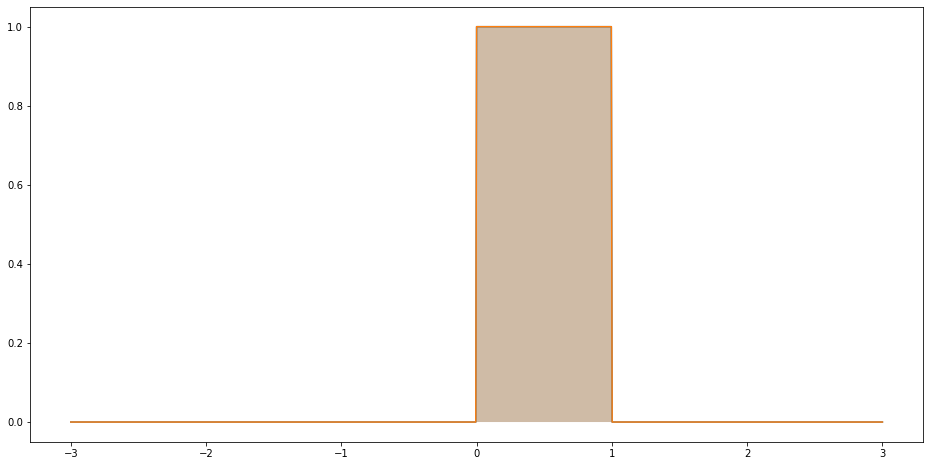

0.0451 (451 из 10000 экспериментов)


In [25]:
first_distr = uniform(0, 1)
second_distr = uniform(0, 1)

plot_distributions(first_distr, second_distr)
test_mann_whitney(first_distr, second_distr, 10);

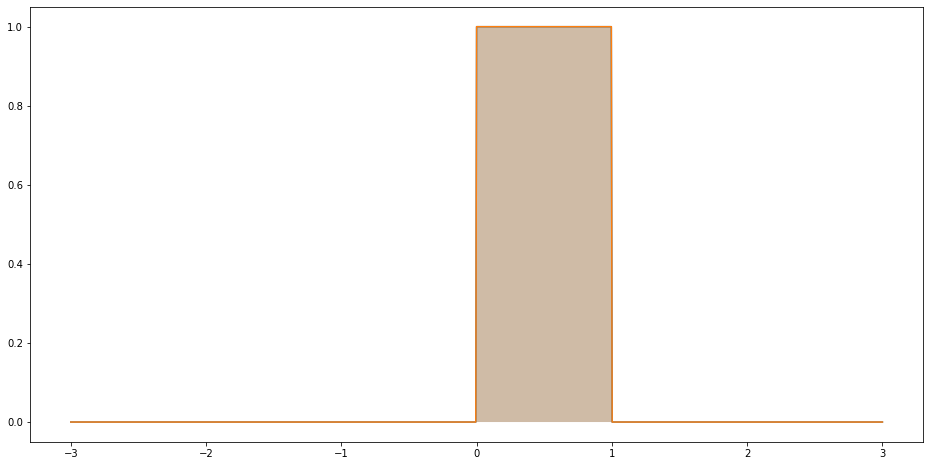

0.0511 (511 из 10000 экспериментов)


In [26]:
first_distr = uniform(0, 1)
second_distr = uniform(0, 1)

plot_distributions(first_distr, second_distr)
test_mann_whitney(first_distr, second_distr, 100);

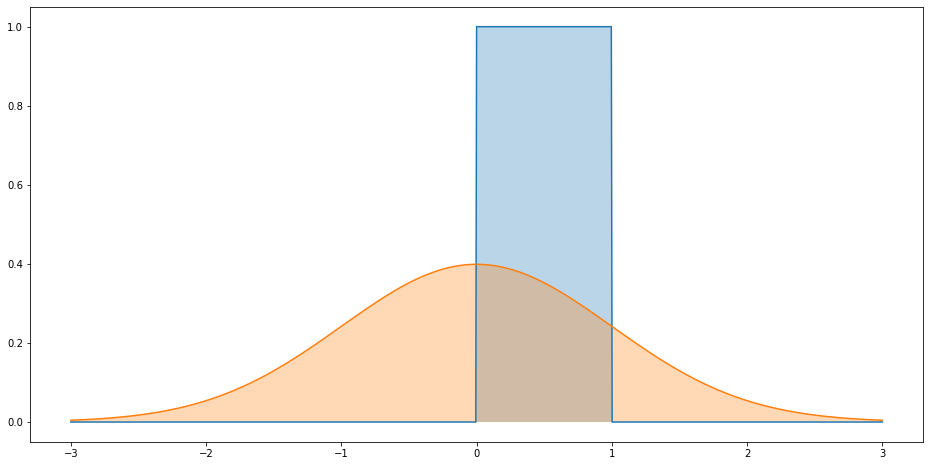

0.686 (6860 из 10000 экспериментов)


In [27]:
first_distr = uniform(0, 1)
second_distr = norm(0, 1)

plot_distributions(first_distr, second_distr)
test_mann_whitney(first_distr, second_distr, 30);

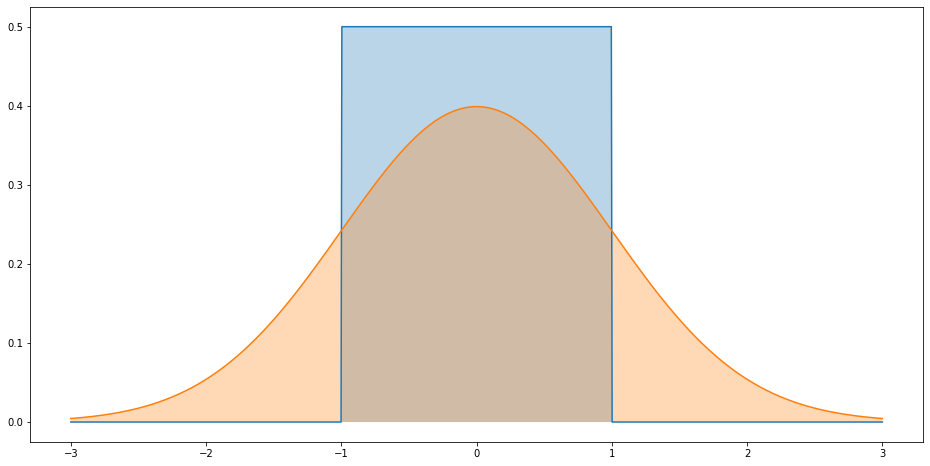

0.0539 (539 из 10000 экспериментов)
0.0772426613987705


In [28]:
first_distr = uniform(-1, 2)
second_distr = norm(0, 1)

plot_distributions(first_distr, second_distr)
rate = test_mann_whitney(first_distr, second_distr, 100)
print(binom_test(rate * 10000, 10000, 0.05))

In [52]:
from scipy.special import binom
from itertools import combinations, product
from functools import lru_cache

@lru_cache(None)
def build_u_stat_distribution(first_sample_size, second_sample_size):
    assert first_sample_size <= 10
    assert second_sample_size <= 10
    total_size = first_sample_size + second_sample_size
    u_stat_max_value = first_sample_size * second_sample_size
    distribution = np.zeros(u_stat_max_value + 1, dtype=np.float64)
    for first_sample_ranks in combinations(range(total_size), first_sample_size):
        u_value = 0
        for i, rank in enumerate(first_sample_ranks):
            u_value += rank - i
        distribution[u_value] += 1
    return distribution / distribution.sum()

def exact_two_sided_mann_whitney(first_sample, second_sample):
    u_stat = sum(a > b for a, b in product(first_sample, second_sample))
    mean_value = len(first_sample) * len(second_sample) / 2
    sample_deviation = abs(u_stat - mean_value)
    distribution = build_u_stat_distribution(len(first_sample), len(second_sample))
    pvalue = 0
    for possible_value, prob in enumerate(distribution):
        deviation = abs(possible_value - mean_value)
        if deviation >= sample_deviation:
            pvalue += prob
    return pvalue

def test_exact_mann_whitney(first_distr, second_distr, sample_size, significance_level=0.05, n_tests=10000):
    positive_results = 0
    for i in range(n_tests):
        first_sample = first_distr.rvs(sample_size)
        second_sample = second_distr.rvs(sample_size)
        pvalue = exact_two_sided_mann_whitney(first_sample, second_sample)
        if pvalue < significance_level:
            positive_results += 1
    return positive_results / n_tests

def calc_u_variance(m, n):
    d = build_u_stat_distribution(m, n)
    vals = np.arange(len(d))
    return (vals ** 2 * d).sum() - (m * n / 2) ** 2

def plot_u_stat_distribution(first_sample_size, second_sample_size):
    plt.figure(figsize=(16, 8))
    u_max = first_sample_size * second_sample_size
    u_values = np.arange(u_max + 1)
    u_distr = build_u_stat_distribution(first_sample_size, second_sample_size)
    
    plt.bar(u_values, u_distr, alpha=0.5, label="true distribution")
    normal_approximation = norm(
        u_max / 2,
        np.sqrt(calc_u_variance(first_sample_size, second_sample_size))
    )
    x = np.linspace(-1, u_max + 1, 10001)
    plt.plot(x, normal_approximation.pdf(x), label="approximation", color="orange")

    plt.xlabel("Значение U-статистики")
    plt.ylabel("Вероятность")
    plt.legend()
    plt.plot()
    plt.show()


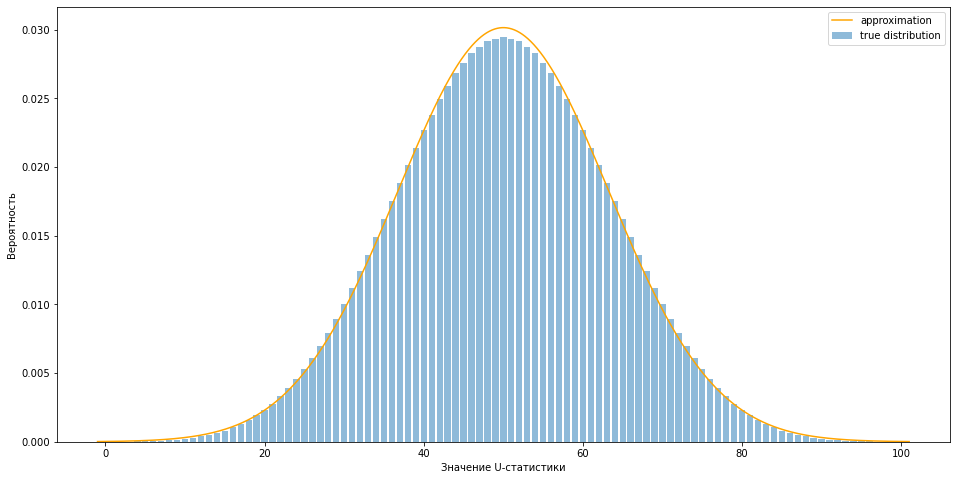

In [53]:
plot_u_stat_distribution(10, 10)

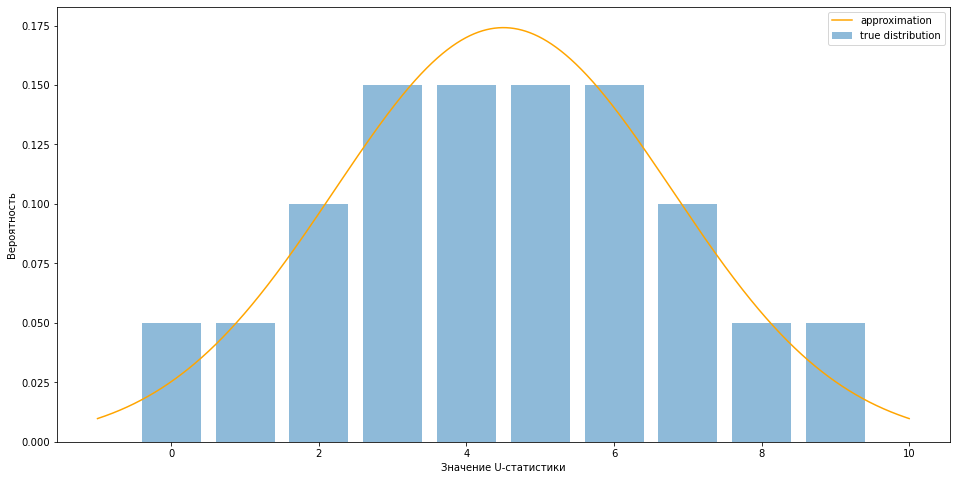

In [54]:
plot_u_stat_distribution(3, 3)

In [55]:
test_exact_mann_whitney(uniform(), uniform(), 10)

0.0421

In [56]:
test_exact_mann_whitney(uniform(), uniform(0, 2), 10)

0.4813